Datathon - Machine Learning Engineering - Grupo 34 - Pos Tech FIAP - 22/05/2025

Applicants

In [265]:
import os
import pandas as pd
import json

def encontrar_arquivo(nome_arquivo, pasta_inicial="."):
    """Busca um arquivo pelo nome a partir da pasta especificada (padrão: pasta atual)."""
    for root, _, files in os.walk(pasta_inicial):
        if nome_arquivo in files:
            return os.path.join(root, nome_arquivo)
    return None

def processar_json(caminho_arquivo):
    with open(caminho_arquivo, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    registros = []
    for id_profissional, dados in data.items():
        registro = {"id_candidato": id_profissional}  # Adiciona o ID como coluna
        
        # Percorre todas as seções do JSON
        for secao, valores in dados.items():
            if isinstance(valores, dict):  # Se a seção tiver subitens, adiciona normalmente
                registro.update(valores)
            else:  # Se for um valor único (ex: cv_pt, cv_en, cargo_atual vazio)
                registro[secao] = valores
        
        registros.append(registro)

    return pd.DataFrame(registros)

# Nome do arquivo JSON
nome_arquivo = "applicants.json"

# Buscar o arquivo no sistema
caminho_arquivo = encontrar_arquivo(nome_arquivo)

if caminho_arquivo:
    applicants = processar_json(caminho_arquivo)
    print("Arquivo encontrado e carregado com sucesso!")
else:
    print("Arquivo não encontrado.")

Arquivo encontrado e carregado com sucesso!


In [266]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [267]:
applicants.shape

(42482, 55)

Vagas

In [268]:
import os
import pandas as pd
import json

def encontrar_arquivo(nome_arquivo, pasta_inicial="."):
    """Busca um arquivo pelo nome a partir da pasta especificada (padrão: pasta atual)."""
    for root, _, files in os.walk(pasta_inicial):
        if nome_arquivo in files:
            return os.path.join(root, nome_arquivo)
    return None

def processar_json(caminho_arquivo):
    with open(caminho_arquivo, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    registros = []
    for id_profissional, dados in data.items():
        registro = {"id_vaga": id_profissional}  # Adiciona o ID como coluna
        
        # Percorre todas as seções do JSON
        for secao, valores in dados.items():
            if isinstance(valores, dict):  # Se a seção tiver subitens, adiciona normalmente
                registro.update(valores)
            else:  # Se for um valor único
                registro[secao] = valores
        
        registros.append(registro)
    
    return pd.DataFrame(registros)

# Nome do arquivo JSON
nome_arquivo = "vagas.json"

# Buscar o arquivo no sistema
caminho_arquivo = encontrar_arquivo(nome_arquivo)

if caminho_arquivo:
    vagas = processar_json(caminho_arquivo)
    print("Arquivo encontrado e carregado com sucesso!")
else:
    print("Arquivo não encontrado.")

Arquivo encontrado e carregado com sucesso!


In [269]:
pd.set_option('display.max_columns', None)

In [270]:
vagas.shape

(14081, 45)

Prospects

In [271]:
import pandas as pd
import json

def processar_json_para_dataframe(json_data):
    dados = []

    for id_vaga, vaga_info in json_data.items():
        titulo = vaga_info.get("titulo", "")
        modalidade = vaga_info.get("modalidade", "")

        # Se houver uma lista dentro do JSON, criamos múltiplas linhas
        if "prospects" in vaga_info:
            for prospect in vaga_info["prospects"]:
                linha = {"id_vaga": id_vaga, "titulo": titulo, "modalidade": modalidade}
                linha.update(prospect)  # Adiciona os dados de prospects como colunas
                dados.append(linha)
        else:
            dados.append({"id_vaga": id_vaga, "titulo": titulo, "modalidade": modalidade})

    return pd.DataFrame(dados)

# Caminho do arquivo JSON
caminho_arquivo = "prospects.json"

# Carregar JSON
with open(caminho_arquivo, "r", encoding="utf-8") as file:
    json_data = json.load(file)

# Converter para DataFrame
prospects = processar_json_para_dataframe(json_data)

In [272]:
pd.set_option('display.max_columns', None)
# Renomeando a coluna 'codigo' para 'id_candidato'
prospects.rename(columns={'codigo': 'id_candidato', 'cidade': 'cidade_vaga'}, inplace=True)

In [273]:
prospects.shape

(53759, 10)

Criando um dataframe único

In [274]:
# Unir Prospects com Applicants (vaga -> candidato)
prospects_applicants = prospects.merge(applicants, left_on="id_candidato", right_on="id_candidato", how="left")

# Unir com Vagas (vaga -> detalhes da vaga)
df = prospects_applicants.merge(vagas, left_on="id_vaga", right_on="id_vaga", how="left")

In [275]:
df.shape

(53759, 108)

In [276]:
# Remover 'nome_y'
df = df.drop(columns=['nome_y'], errors='ignore')

# Renomear colunas
df = df.rename(columns=lambda col: col.replace('_x', '_candidato').replace('_y', '_vaga'))
df = df.rename(columns={"local": "cidade_candidato", "cidade": "cidade_vaga", "nivel profissional": "nivel_profissional_vaga", 
                        "areas_atuacao": "areas_atuacao_vaga", "nivel_profissional": "nivel_profissional_candidato",
                        "cursos": "cursos_candidato", "remuneracao": "remuneracao_candidato"})

Tratamento e análise da base

In [277]:
df = df[['situacao_candidado','recrutador','cidade_candidato',
                'data_nascimento','sexo','estado_civil','pcd','remuneracao_candidato','nivel_profissional_candidato',
                'nivel_academico_candidato',
                'nivel_ingles_candidato','nivel_espanhol_candidato','cursos_candidato',
                'cliente_vaga','tipo_contratacao',
                'prioridade_vaga','origem_vaga','cidade_vaga',
                'nivel_profissional_vaga','nivel_academico_vaga','nivel_ingles_vaga','nivel_espanhol_vaga',
                'areas_atuacao_vaga','ultima_atualizacao']]

In [278]:
df.shape

(53759, 24)

In [279]:
print(f'Linhas duplicadas: {df.duplicated().sum()}')

Linhas duplicadas: 8274


In [280]:
df.drop_duplicates(inplace=True)  # Remove duplicatas

In [281]:
# Convertendo as colunas para datetime, tratando erros
df[['data_nascimento','ultima_atualizacao']] = df[
    ['data_nascimento','ultima_atualizacao']].apply(
    lambda col: pd.to_datetime(col, errors='coerce', format='%d-%m-%Y'))

In [282]:
# Extraindo apenas os números e convertendo para inteiro
df['remuneracao_candidato'] = (
    df['remuneracao_candidato']
    .str.replace(r'[^\d,.-]', '', regex=True)  # Remove tudo que não for número, vírgula, ponto ou hífen
    .str.replace(',', '.', regex=False)  # Substitui vírgula por ponto
    .str.extract(r'(-?\d+\.?\d*)')  # Captura o primeiro número válido
    .astype(float)  # Converte para float primeiro
    .fillna(0)  # Substitui NaN por 0 (opcional)
    .astype(int)  # Converte para inteiro
)

In [283]:
# Calculando a idade (diferenca entre anos)
df['idade'] = df['ultima_atualizacao'].dt.year - df['data_nascimento'].dt.year
# Removendo as colunas 'data_nascimento' e 'ultima_atualizacao'
df = df.drop(columns=['data_nascimento', 'ultima_atualizacao'])

In [284]:
df.describe(include="all")

,situacao_candidado,recrutador,cidade_candidato,sexo,estado_civil,pcd,remuneracao_candidato,nivel_profissional_candidato,nivel_academico_candidato,nivel_ingles_candidato,nivel_espanhol_candidato,cursos_candidato,cliente_vaga,tipo_contratacao,prioridade_vaga,origem_vaga,cidade_vaga,nivel_profissional_vaga,nivel_academico_vaga,nivel_ingles_vaga,nivel_espanhol_vaga,areas_atuacao_vaga,idade
count,45485,45485,39281,39281,39281,39281,4.548500e+04,39281,39281,39281,39281,10901,45462,45462,45462,45462,45462,45462,45462,45462,45462,45462,14114.000000
unique,21,77,615,3,7,3,NaN,10,22,6,6,127,111,40,4,3,155,14,15,6,7,71,NaN
top,Prospect,Srta. Bella Ferreira,,,,,NaN,,,,,,Morrison Ltd,PJ/Autônomo,Alta: Alta complexidade 3 a 5 dias,Nova Posição,São Paulo,Sênior,Ensino Superior Completo,Básico,Nenhum,TI - Projetos-,NaN
freq,15430,4462,18802,26683,28605,28974,NaN,38988,27564,28092,28392,1065,6274,15694,30139,30012,32801,18014,35135,15790,20235,18005,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,1.996147e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.983562
std,NaN,NaN,NaN,NaN,NaN,NaN,1.455928e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.234396
min,NaN,NaN,NaN,NaN,NaN,NaN,-4.700000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.000000


In [285]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45485 entries, 0 to 53758
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   situacao_candidado            45485 non-null  object 
 1   recrutador                    45485 non-null  object 
 2   cidade_candidato              39281 non-null  object 
 3   sexo                          39281 non-null  object 
 4   estado_civil                  39281 non-null  object 
 5   pcd                           39281 non-null  object 
 6   remuneracao_candidato         45485 non-null  int32  
 7   nivel_profissional_candidato  39281 non-null  object 
 8   nivel_academico_candidato     39281 non-null  object 
 9   nivel_ingles_candidato        39281 non-null  object 
 10  nivel_espanhol_candidato      39281 non-null  object 
 11  cursos_candidato              10901 non-null  object 
 12  cliente_vaga                  45462 non-null  object 
 13  tipo_c

Análise Exploratória de Dados

In [286]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

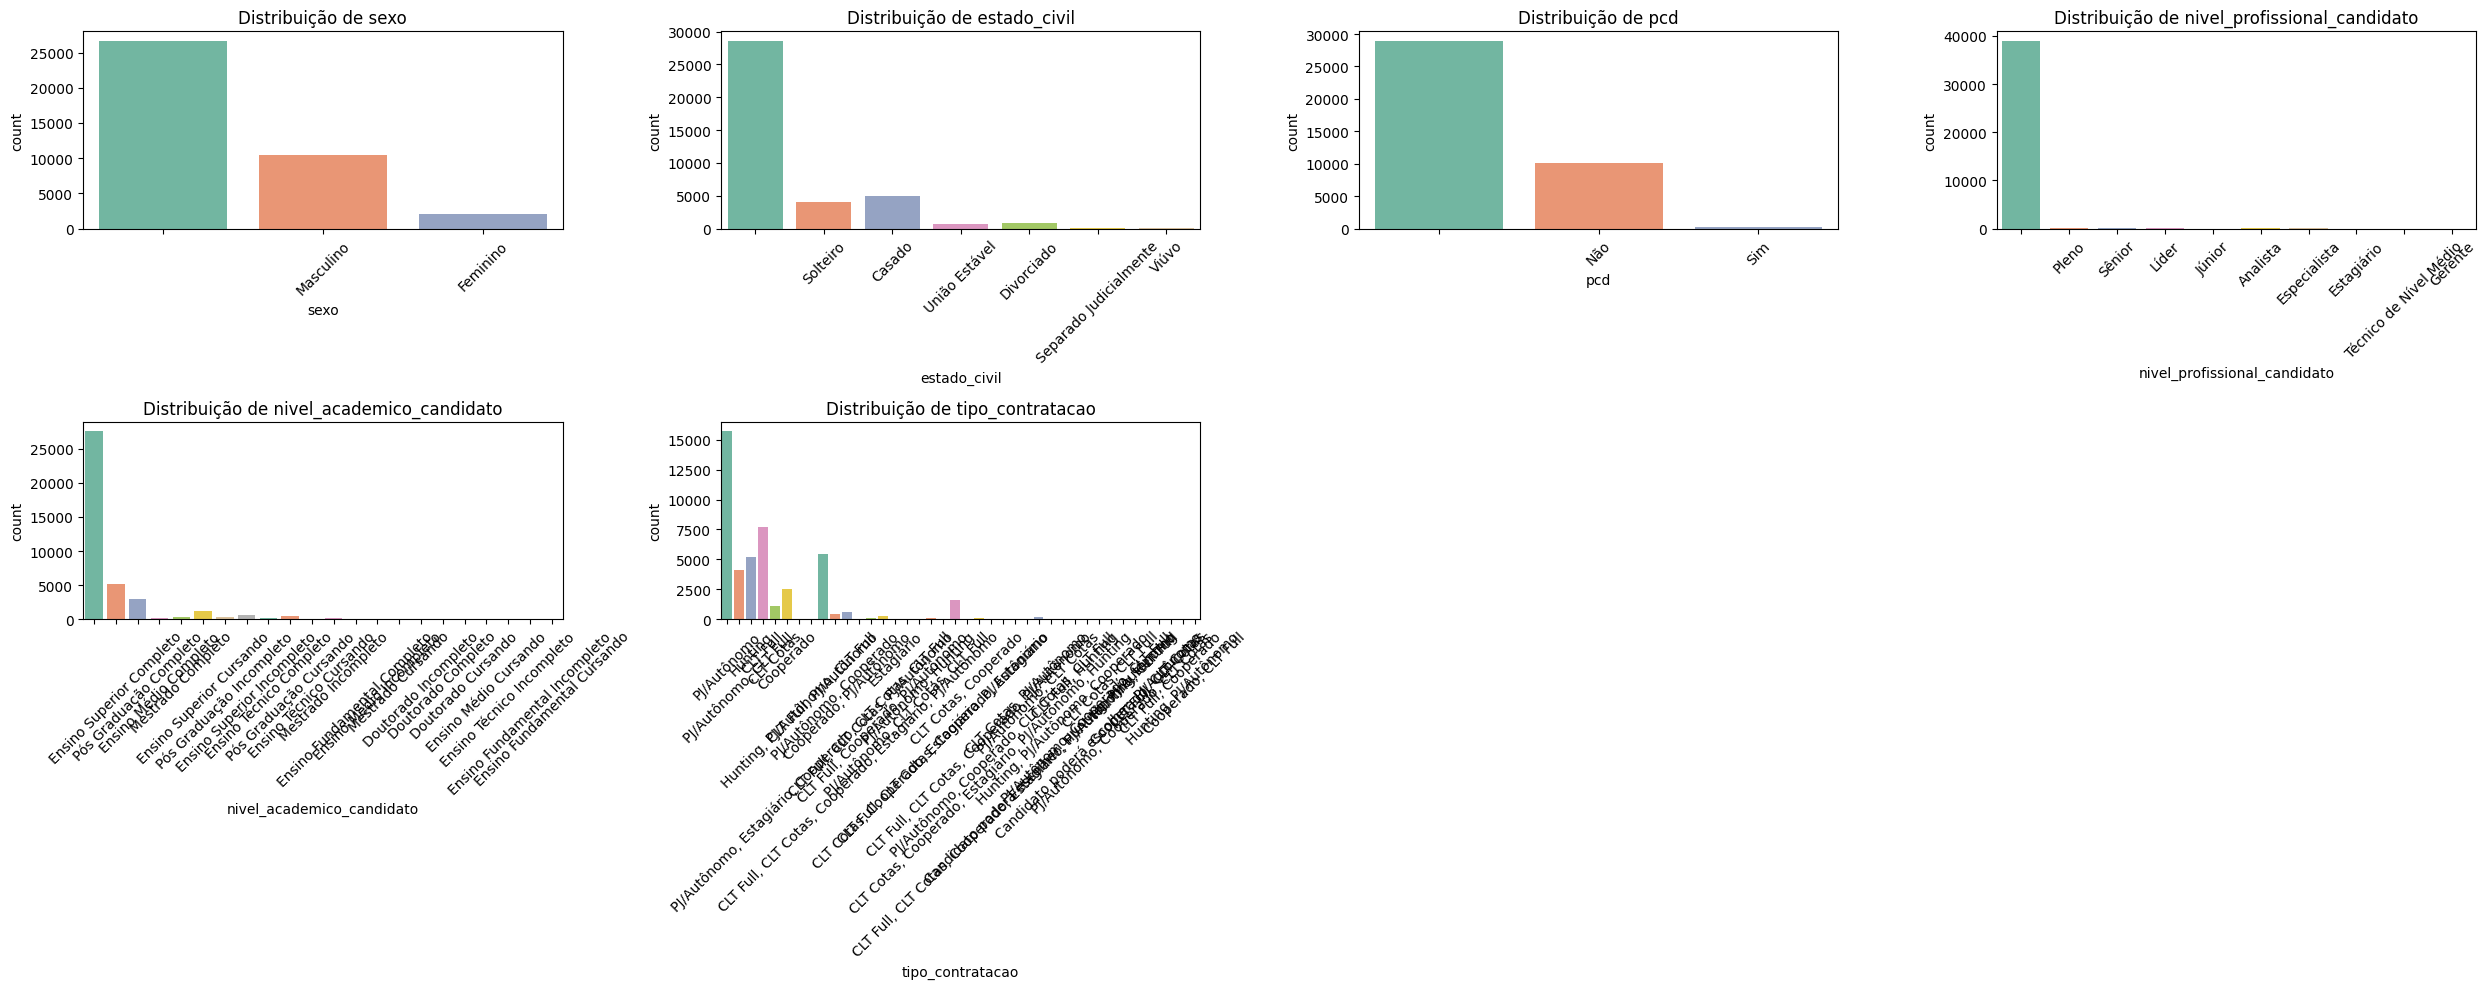

In [287]:
import warnings
warnings.filterwarnings("ignore")

# Gráficos de barras para variáveis categóricas
categorical_columns = ['sexo', 'estado_civil', 'pcd', 'nivel_profissional_candidato', 'nivel_academico_candidato', 'tipo_contratacao']

plt.figure(figsize=(25, 10))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(2, 4, i)
    sns.countplot(x=df[col], palette='Set2')
    plt.title(f'Distribuição de {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

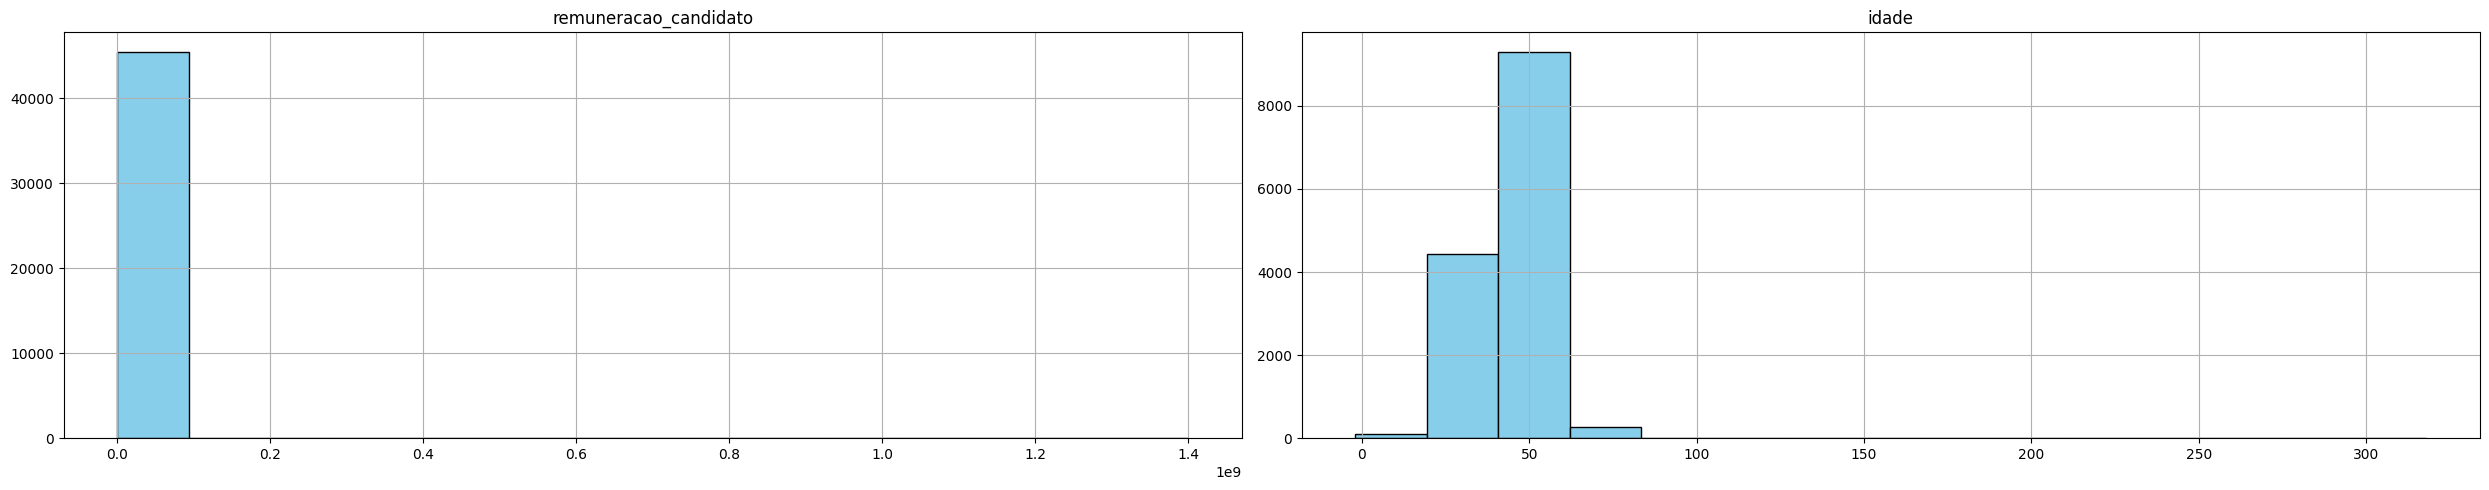

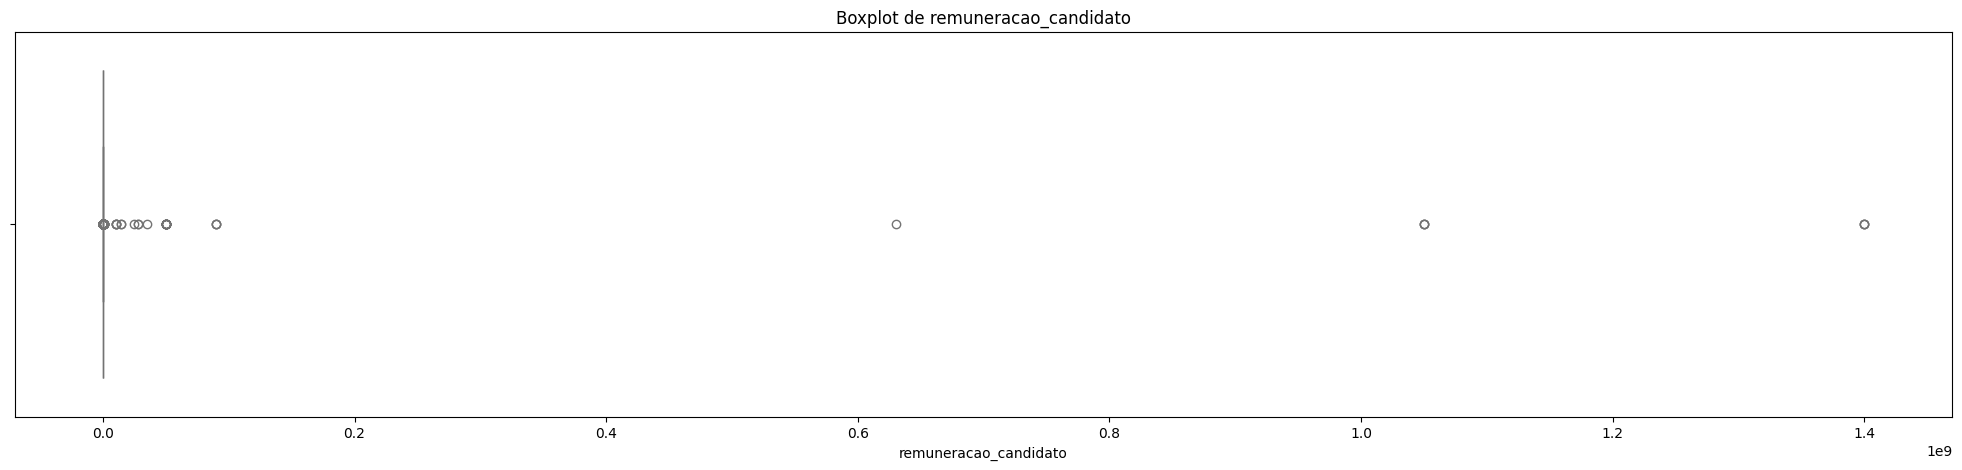

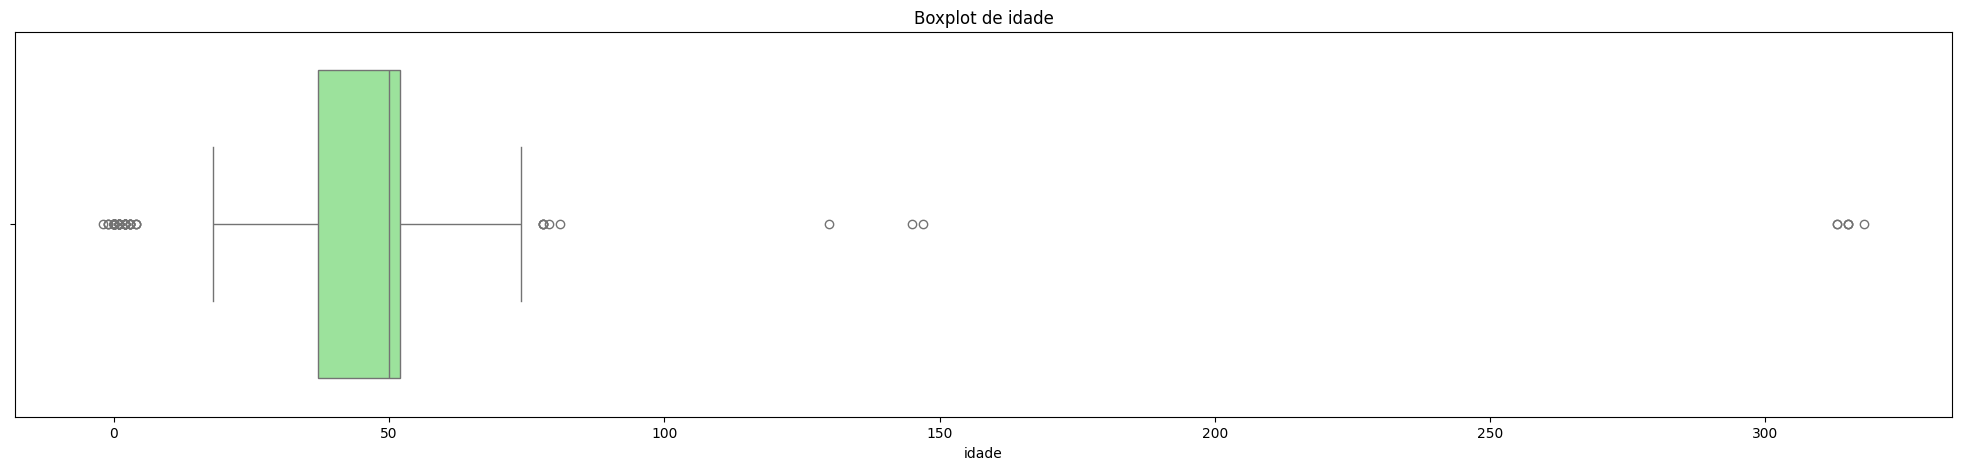

In [288]:
# Histograma para variáveis numéricas
numeric_columns = ['remuneracao_candidato', 'idade']
df[numeric_columns].hist(bins=15, figsize=(25, 5), color='skyblue', edgecolor='black')
plt.tight_layout()
plt.show()

# Boxplot para detectar outliers
for col in numeric_columns:
    plt.figure(figsize=(25, 5))
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f'Boxplot de {col}')
    plt.show()

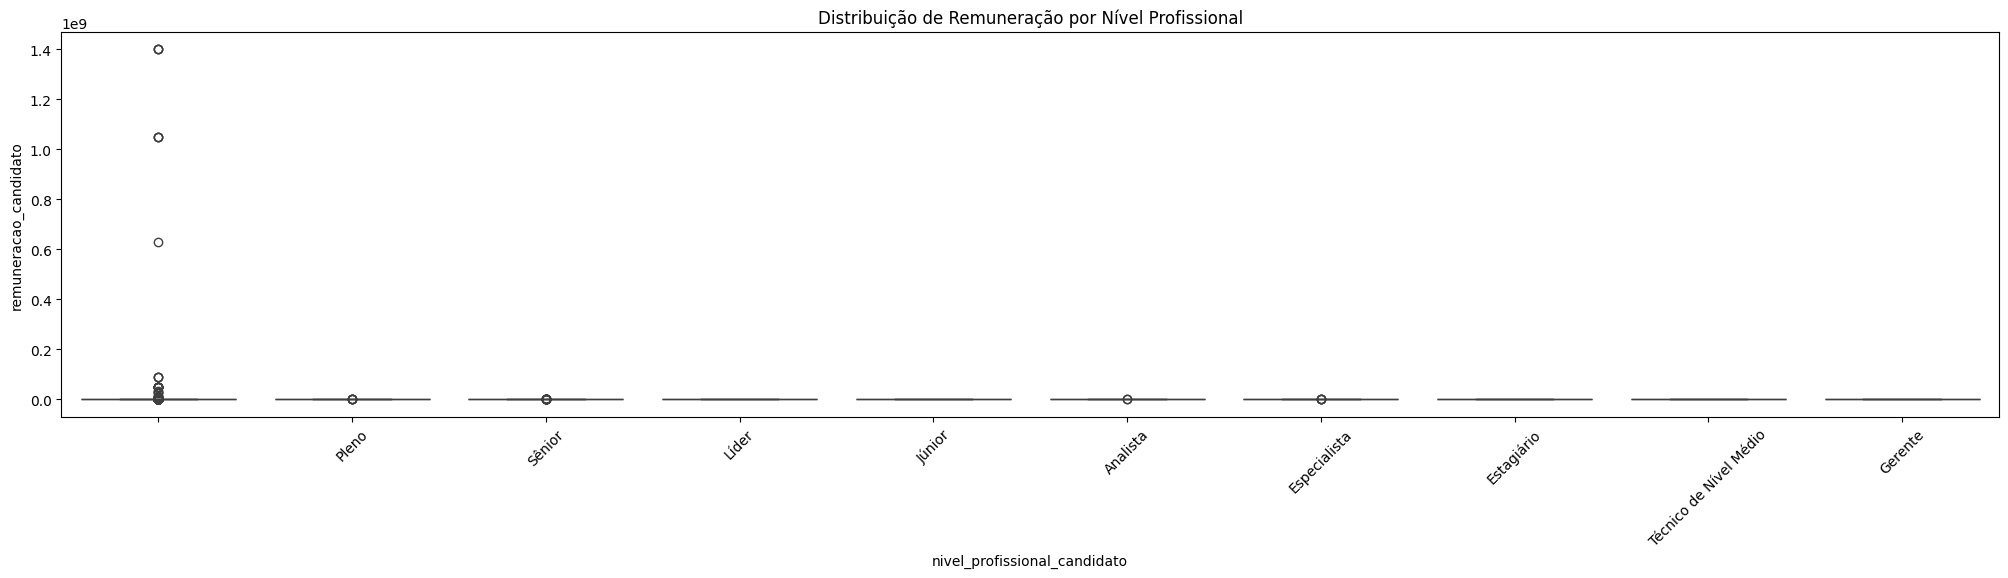

In [289]:
# Exemplo para 'remuneracao' e 'nivel_profissional'
plt.figure(figsize=(25, 5))
sns.boxplot(x='nivel_profissional_candidato', y='remuneracao_candidato', data=df)
plt.title('Distribuição de Remuneração por Nível Profissional')
plt.xticks(rotation=45)
plt.show()

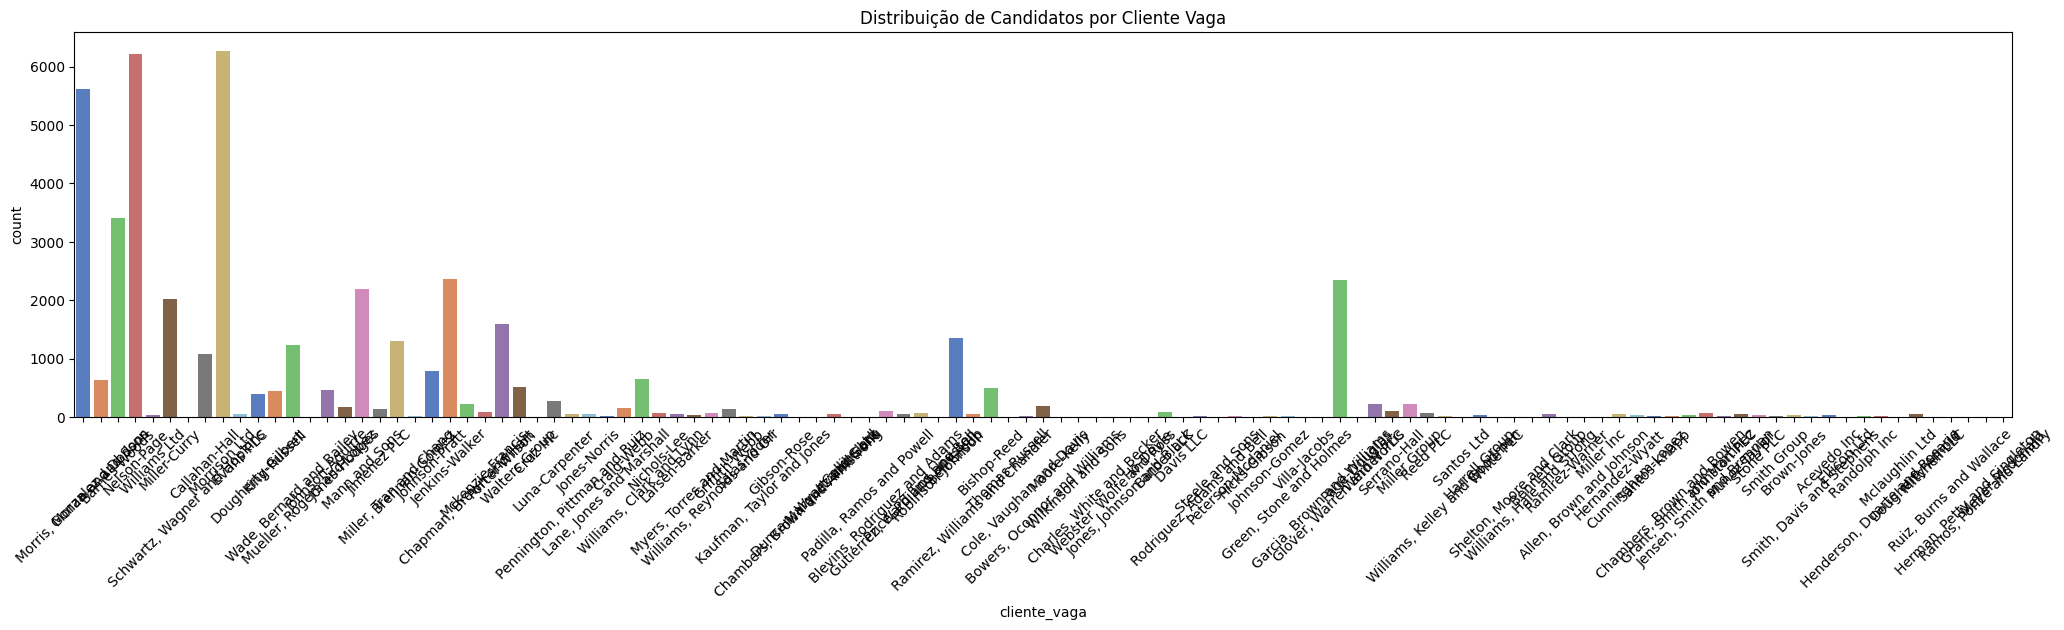

In [290]:
# Distribuição de candidatos por tipo de vaga
plt.figure(figsize=(25, 5))
sns.countplot(x='cliente_vaga', data=df, palette='muted')
plt.title('Distribuição de Candidatos por Cliente Vaga')
plt.xticks(rotation=45)
plt.show()

In [291]:
# Visualizando valores extremos
df[df['idade'] < 18].head(1)  # Se houver idades menores que 18, pode ser um erro

,situacao_candidado,recrutador,cidade_candidato,sexo,estado_civil,pcd,remuneracao_candidato,nivel_profissional_candidato,nivel_academico_candidato,nivel_ingles_candidato,nivel_espanhol_candidato,cursos_candidato,cliente_vaga,tipo_contratacao,prioridade_vaga,origem_vaga,cidade_vaga,nivel_profissional_vaga,nivel_academico_vaga,nivel_ingles_vaga,nivel_espanhol_vaga,areas_atuacao_vaga,idade
41,Prospect,Ana Camargo,"Brasília, Distrito Federal",Masculino,Solteiro,Não,10300,,Ensino Superior Completo,Intermediário,Básico,Sistemas de Informação,Gonzalez and Sons,Hunting,Média: Média complexidade 6 a 10 dias,Nova Posição,São Paulo,Sênior,Ensino Médio Completo,Nenhum,Nenhum,Financeira/Controladoria-,0.0


In [292]:
# Visualizando valores extremos
df[df['remuneracao_candidato'] > 1000000].head(1)  # Verificando se há remunerações extremamente altas

,situacao_candidado,recrutador,cidade_candidato,sexo,estado_civil,pcd,remuneracao_candidato,nivel_profissional_candidato,nivel_academico_candidato,nivel_ingles_candidato,nivel_espanhol_candidato,cursos_candidato,cliente_vaga,tipo_contratacao,prioridade_vaga,origem_vaga,cidade_vaga,nivel_profissional_vaga,nivel_academico_vaga,nivel_ingles_vaga,nivel_espanhol_vaga,areas_atuacao_vaga,idade
4688,Prospect,Yasmin da Rosa,"Araguari, Minas Gerais",Masculino,Casado,Não,50001600,,Ensino Superior Completo,Intermediário,Básico,Engenharia de Controle e Automação,Jenkins-Walker,Hunting,Alta: Alta complexidade 3 a 5 dias,,São Leopoldo,Sênior,Ensino Superior Completo,Avançado,Avançado,TI - Infraestrutura-,49.0


Tratamento das variáveis

In [293]:
valores_positivos = ['Contratado pela Decision', 'Aprovado', 'Contratado como Hunting', 'Proposta Aceita']

df['situacao_candidado'] = df['situacao_candidado'].isin(valores_positivos).astype(int)

1. Label Encoding (Se as categorias forem ordinais, ou seja, possuem uma ordem)

In [294]:
from sklearn.preprocessing import LabelEncoder

# Supondo que 'coluna_categorica' seja a sua coluna categórica
le = LabelEncoder()

# Lista das colunas a codificar
colunas_categoricas = ['nivel_profissional_candidato', 'nivel_academico_candidato', 'nivel_ingles_candidato', 
                       'nivel_espanhol_candidato', 'prioridade_vaga', 'nivel_profissional_vaga', 
                       'nivel_academico_vaga', 'nivel_ingles_vaga', 'nivel_espanhol_vaga', 'sexo', 'estado_civil', 'pcd','recrutador', 'cidade_candidato','cursos_candidato','cliente_vaga', 'tipo_contratacao',
                       'origem_vaga', 'cidade_vaga','areas_atuacao_vaga']

# Aplicando o LabelEncoder em cada coluna categórica
for coluna in colunas_categoricas:
    df[coluna] = le.fit_transform(df[coluna])

2. One-Hot Encoding (Se as categorias forem nominais, sem uma ordem específica)

In [295]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# Supondo que seu DataFrame se chame df
#colunas_categoricas_simples = ['sexo', 'estado_civil', 'pcd','cursos_candidato', 'areas_atuacao_vaga','recrutador']
#colunas_multivalor = ['cursos_candidato', 'areas_atuacao_vaga','recrutador']

# Aplicar One-Hot Encoding nas colunas categóricas normais
#df_encoded = df.copy()
#for col in colunas_categoricas_simples:
#    df_encoded[col] = df_encoded[col].astype('category').cat.codes

# Tratar colunas com múltiplos valores
#mlb = MultiLabelBinarizer()
#for col in colunas_multivalor:
#    df[col] = df[col].astype(str).apply(lambda x: x.split('-'))  # Ajuste o delimitador conforme necessário
#    encoded_multivalor = pd.DataFrame(mlb.fit_transform(df[col]), columns=[f"{col}_{c}" for c in mlb.classes_])
#    df_encoded = pd.concat([df_encoded, encoded_multivalor], axis=1)

# Manter as colunas originais na saída
#df = df[df.columns]

#df.head()

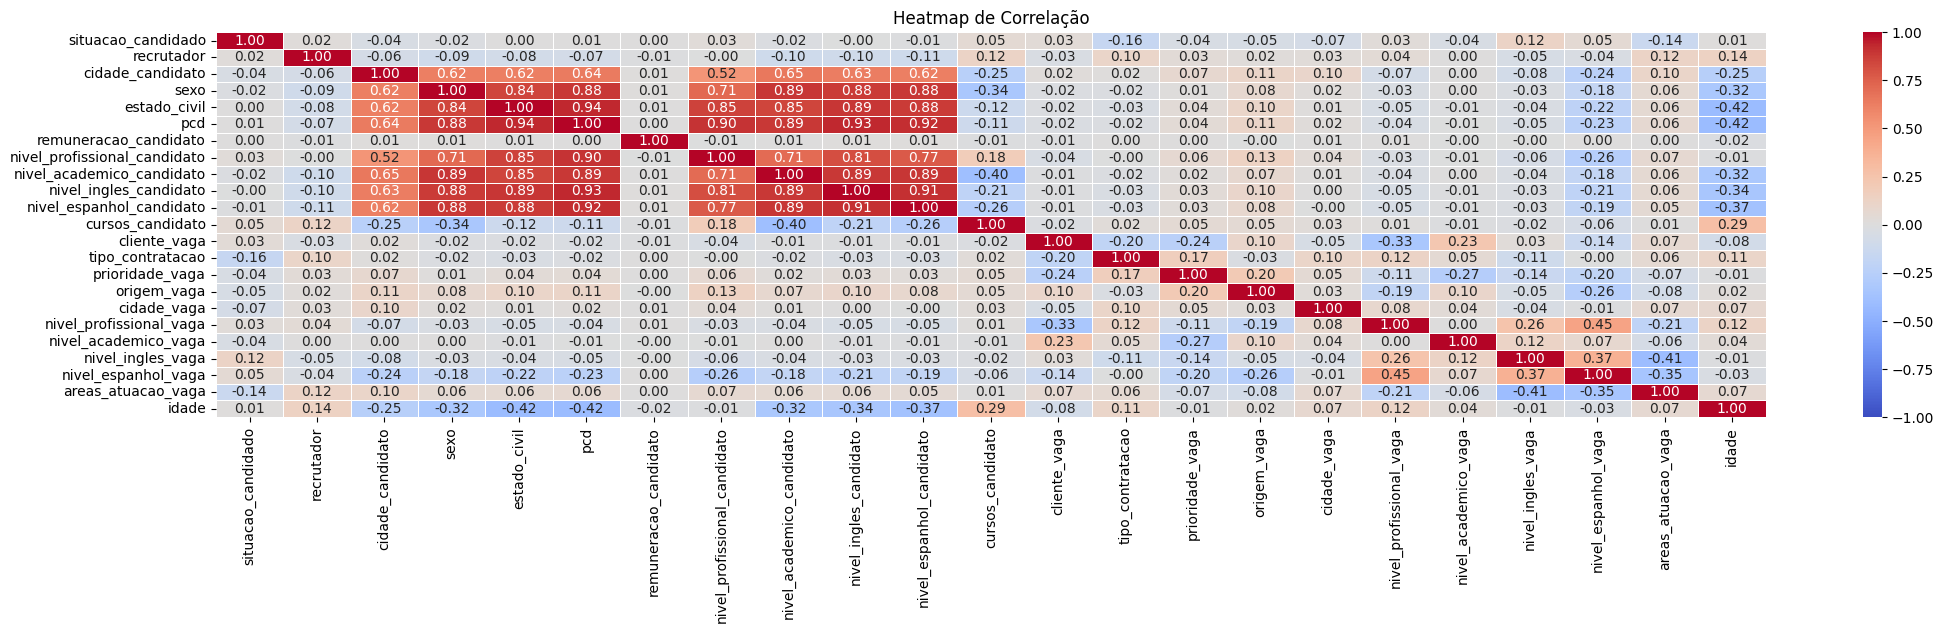

In [298]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcula a correlação
correlation_matrix = df.corr()

# Ajusta o tamanho da figura
plt.figure(figsize=(25, 5))

# Cria o heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)

# Título
plt.title("Heatmap de Correlação")

# Exibir o gráfico
plt.show()